In [14]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Functions to get parsed data out of CSV:

In [15]:
def read_in_relevant_data(parent_file_path, treatment_number):
    '''Function which takes the relevant data out of the CSV file for a certain treatment's statistics'''
    
    file_path = parent_file_path + str(treatment_number) + ".csv"
    df = pd.read_csv(file_path) #read in as pandas data frame
	
    audio_ellen = {
		'packetLoss': df['RIA_fractionLost_ellen'].tolist(),
		'bitRate': df['IT01A_bytesReceived_in_bits/s_ellen'].tolist(),
		'roundTripTime': df['RIA_roundTripTime_ellen'].tolist(),
		'bufferDelay': df['IT01A_jitterBufferDelay/emissions_ellen'].tolist(),
		'fec': df['IT01A_(dtx, fec)_ellen'].tolist(),
		'dtx': df['IT01A_(dtx, fec)_ellen'].tolist()}
    video_ellen = {
		'packetLoss': df['RIV_fractionLost_ellen'].tolist(),
		'bitRate': df['IT01V_bytesReceived_in_bits/s_ellen'].tolist(),
		'roundTripTime': df['RIV_roundTripTime_ellen'].tolist(), 
		'bufferDelay': df['IT01V_jitterBufferDelay/emissions_ellen'].tolist(),
		'codec': df['IT01V_codec_ellen'].tolist(),
		'width': df['IT01V_frameWidth_ellen'].tolist(),
		'expectedWidth': df['SV2_width_ellen'].tolist(),
		'height': df['IT01V_frameHeight_ellen'].tolist(),
		'expectedHeight': df['SV2_height_ellen'].tolist(),
		'frameRate': df['IT01V_framesPerSecond_ellen'].tolist(),
		'expectedFrameRate': df['SV2_framesPerSecond_ellen'].tolist()}
    audio_aadya = {
		'packetLoss': df['RIA_fractionLost_aadya'].tolist(),
		'bitRate': df['IT01A_bytesReceived_in_bits/s_aadya'].tolist(),
		'roundTripTime': df['RIA_roundTripTime_aadya'].tolist(),
		'bufferDelay': df['IT01A_jitterBufferDelay/emissions_aadya'].tolist(),
		'fec': df['IT01A_(dtx, fec)_aadya'].tolist(),
		'dtx': df['IT01A_(dtx, fec)_aadya'].tolist()}
    video_aadya = {
		'packetLoss': df['RIV_fractionLost_aadya'].tolist(),
		'bitRate': df['IT01V_bytesReceived_in_bits/s_aadya'].tolist(),
		'roundTripTime': df['RIV_roundTripTime_aadya'].tolist(), 
		'bufferDelay': df['IT01V_jitterBufferDelay/emissions_aadya'].tolist(),
		'codec': df['IT01V_codec_aadya'].tolist(),
		'width': df['IT01V_frameWidth_aadya'].tolist(),
		'expectedWidth': df['SV2_width_aadya'].tolist(),
		'height': df['IT01V_frameHeight_aadya'].tolist(),
		'expectedHeight': df['SV2_height_aadya'].tolist(),
		'frameRate': df['IT01V_framesPerSecond_aadya'].tolist(),
		'expectedFrameRate': df['SV2_framesPerSecond_aadya'].tolist()}
	
    return audio_ellen, video_ellen, audio_aadya, video_aadya


def graph_crossover(audio_ellen, video_ellen, audio_aadya, video_aadya):
	'''function to graph the times the each statistic has/doesn't have data for'''

	plt.figure(figsize=(13, 9))
	plot1 = plt.subplot2grid((9, 13), (0, 0), rowspan=9, colspan=6)
	plot2 = plt.subplot2grid((9, 13), (0, 7), rowspan=9, colspan=6)
	
	colours = ["forestgreen", "lime", "mediumseagreen", "aquamarine", "turquoise", "lightseagreen", "mediumturquoise","paleturquoise", "darkslategray", "teal", "darkcyan", "c", "cyan", "darkturquoise", "cadetblue", "powderblue", "lightblue"]
	col = 0
	y_translation = 0
	
	for key, val in audio_ellen.items():
		temp_vals = []
		for i in range(len(val)):
			if val[i] == -1 or val[i] == "-1":
				temp_vals.append(y_translation)
			else:
				temp_vals.append(y_translation + 4)
		plot1.plot(range(len(temp_vals)), temp_vals, label=key, color=colours[col])
		col += 1
		y_translation += 5

	for key, val in video_ellen.items():
		temp_vals = []
		for i in range(len(val)):
			if val[i] == -1 or val[i] == "-1":
				temp_vals.append(y_translation)
			else:
				temp_vals.append(y_translation + 4)
		plot1.plot(range(len(temp_vals)), temp_vals, label=key, color=colours[col])
		col += 1
		y_translation += 5

	col = 0
	y_translation = 0
	
	for key, val in audio_aadya.items():
		temp_vals = []
		for i in range(len(val)):
			if val[i] == -1 or val[i] == "-1":
				temp_vals.append(y_translation)
			else:
				temp_vals.append(y_translation + 4)
		plot2.plot(range(len(temp_vals)), temp_vals, label=key, color=colours[col])
		col += 1
		y_translation += 5

	for key, val in video_aadya.items():
		temp_vals = []
		for i in range(len(val)):
			if val[i] == -1 or val[i] == "-1":
				temp_vals.append(y_translation)
			else:
				temp_vals.append(y_translation + 4)
		plot2.plot(range(len(temp_vals)), temp_vals, label=key, color=colours[col])
		col += 1
		y_translation += 5
	
	plot1.legend()
	plot2.legend()
	plot1.set_title("Ellen's side")
	plot2.set_title("Aadya's side")
	plot1.set_yticklabels([])
	plot2.set_yticklabels([])
	plot1.set_xlabel("Seconds")
	plot2.set_xlabel("Seconds")
	plt.show()


def find_non_null_timestamps(stats_dict):
	'''Function to find the roughly 30 second range of timestamps which Web RTC consistently provides data for.'''

	global_leftmost = -1
	global_rightmost = 99999999999
	for key, val in stats_dict.items():
		leftmost = None
		rightmost = None
		for i in range(len(val)):
			if val[i] != -1 and val[i] != "-1":
				if leftmost == None:
					leftmost = i
					rightmost = i
				if rightmost != None:
					rightmost = i
			elif (val[i] == -1 or val[i] == "-1") and rightmost != None:
				break
		if leftmost > global_leftmost:
			global_leftmost = leftmost
		if rightmost < global_rightmost:
			global_rightmost = rightmost

	return global_leftmost + 1, global_rightmost

(29, 54)


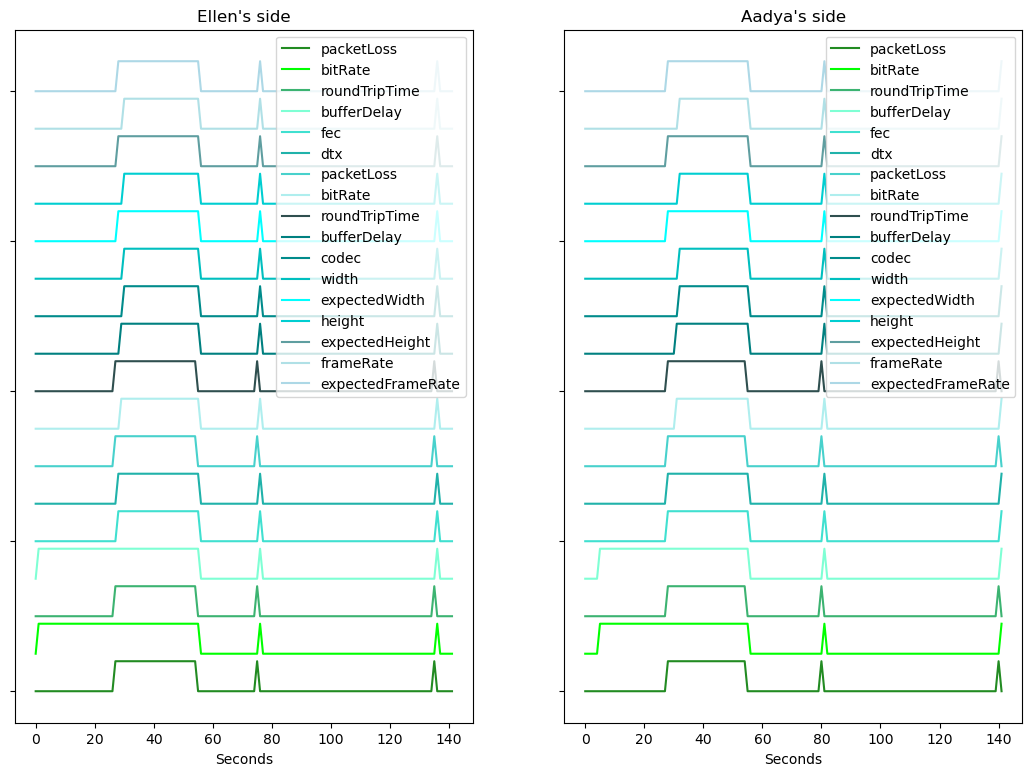

In [3]:
parent_file_path = '../CSVs/stage_one/treatment'
treatment_number = 1
audio_ellen, video_ellen, audio_aadya, video_aadya = read_in_relevant_data(parent_file_path, treatment_number)
print(find_non_null_timestamps(audio_ellen))
graph_crossover(audio_ellen, video_ellen, audio_aadya, video_aadya)

## Main MOS scoring functions:

In [16]:
'''
Audio stats dictionary contains these params:

 * packetLoss: 0-100%
 * bitrate: bps
 * roundTripTime: ms
 * bufferDelay: ms
 * fec: boolean (ony used for audio)
 * dtx: boolean (ony used for audio)

Video stats dictionary contains these params:

 * packetLoss: 0-100%
 * bitrate: bps
 * roundTripTime: ms
 * bufferDelay: ms
 * codec: opus / vp8 / vp9 / h264 (only used for video) **EDIT THIS --> maybe add AV1 codec
 * width: number; Resolution of the video received
 * expectedWidth: number; Resolution of the rendering widget
 * height: number; Resolution of the video received
 * expectedHeight: number; Resolution of the rendering widget
 * frameRate: number; FrameRate of the video received
 * expectedFrameRate: number; FrameRate of the video source
'''


def clamp(val, minimum, maximum):
	'''Function which returns a value if it's within a given range,
	or the minimum of the range or maximum of the range if the value is
	outside of the bounds of the range.'''
	if val >= minimum:
		if val <= maximum:
			return val
		else:
			return maximum
	else:
		return minimum
	

def score_audio(audio_stats):
	'''Function to generate an MOS score for the audio for a single second of a call. Uses the
	E-Model algorithm.'''

	R0 = 100 #initial rating (starts at max 100)
	
    # CALCULATING EQUIPTMENT IMPAIRMENT
	if audio_stats['dtx'] == True:
		EI = 8
	elif audio_stats['bitRate'] != 0:
			value = 55 - 4.6 * math.log(audio_stats['bitRate'])
			EI = clamp(value, 0, 30)
	else:
		EI = 6

    # CALCULATING PACKET LOSS IMPAIRMENT
	PL = audio_stats['packetLoss'] #Packet Loss
	#Packet Loss Robustness Factor
	if audio_stats['fec'] == True:
		PLRF = 20
	else:
		PLRF = 10   
	PLI = EI + (100 - EI) * (PL / (PL + PLRF)) #Packet Loss Impairment
	
    # CALCULATING DELAY IMPAIRMENT
	delay = 20 + audio_stats['bufferDelay'] + audio_stats['roundTripTime'] / 2 #function of rtt and buffering
	if delay > 150:
		DI = delay * 0.03 + (0.1 * (delay - 150)) #Delay Impairment
	else:
		DI = delay * 0.03
	
    # CALCULATING FINAL SCORE
	R = clamp(R0 - PLI - DI, 0, 100) #Rating
	MOS_raw = 1 + 0.035 * R + (R * (R - 60) * (100 - R) * 7) / 1000000 
	MOS = clamp(round(MOS_raw * 100) / 100, 1, 5) #MOS score bounded between 1-5 to 2 dp
	
	return MOS


def score_video(video_stats):
	'''Function to generate an MOS score for the video for a single second of a call. '''
	
	pixels = video_stats['width'] * video_stats['height']
	
	#increased quality from codec used
	if (video_stats['codec'] == 'VP9') or (video_stats['codec'] == 'AV1'):
		codec_factor = 1.2
	else:
		codec_factor = 1.0
	
	delay = video_stats['bufferDelay'] + video_stats['roundTripTime'] / 2
	
	FR = video_stats['frameRate']
	if FR != 0:
		
		bPPPF = (codec_factor * video_stats['bitRate']) / pixels / FR
		if bPPPF == 0:
			base = 1
		else:
			base = clamp(0.56 * math.log(bPPPF) + 5.36, 1, 5)
		if video_stats['expectedFrameRate'] == 0:
			MOS_raw = base - delay * 0.002
		else:
			MOS_raw = base - 1.9 * math.log(video_stats['expectedFrameRate'] / FR) - delay * 0.002
		MOS = clamp(round(MOS_raw * 100) / 100, 1, 5) #MOS score bounded between 1-5 to 2 dp
	
	else:
		MOS = 1
	
	return MOS


## Aggregation functions:

In [17]:
def find_MOS_across_range(all_audio, all_video):

    audio_leftmost, audio_rightmost = find_non_null_timestamps(all_audio)
    video_leftmost, video_rightmost = find_non_null_timestamps(all_video)

    audio_MOSs = []
    for a in range(audio_leftmost, audio_rightmost + 1):
        a_second_stats = {
            'packetLoss': all_audio['packetLoss'][a] * 100,
            'roundTripTime': all_audio['roundTripTime'][a] * 1000,
            'bufferDelay': all_audio['bufferDelay'][a],
            'bitRate': all_audio['bitRate'][a],
            'fec': eval(all_audio['fec'][a])[1],
            'dtx': eval(all_audio['dtx'][a])[0]}
        audio_MOSs.append(score_audio(a_second_stats))

    video_MOSs = []
    for v in range(video_leftmost, video_rightmost + 1):
        v_second_stats = {}
        for key, val in all_video.items():
            v_second_stats[key] = val[v]
        v_second_stats['packetLoss'] = v_second_stats['packetLoss'] * 100
        video_MOSs.append(score_video(v_second_stats))

    return audio_MOSs, video_MOSs

def aggregate_MOSs_across_call(MOSs, percentile=5):
    '''going for an 'almost minimum' (truncated minimum) aggregation approach: 
    takes the nth percentile (or (100-n)th percentile worst) to avoid extreme outliers.
    5th percentile is chosen as default.'''
    data_array = np.array(MOSs)
    almost_min_value = np.percentile(data_array, percentile)
    return almost_min_value

def aggregate_video_and_audio_MOS_true_mean(video_MOS, audio_MOS):
    '''simple aggregation by taking the mean'''
    return (video_MOS + audio_MOS) / 2

def aggregate_video_and_audio_MOS_harmonic_mean(video_MOS, audio_MOS):
    '''aggregation by taking the harmonic mean to give more weighting to the worse value'''
    hmean = (2 * video_MOS * audio_MOS) / (video_MOS + audio_MOS)
    return round(hmean * 100) / 100

def aggregate_ellen_aadya_MOS(ellen_MOS, aadya_MOS):
    '''simple aggregation by taking the mean'''
    return min(ellen_MOS, aadya_MOS)


In [18]:
parent_file_path = '../CSVs/stage_one/treatment'
treatment_number = 1
audio_ellen, video_ellen, audio_aadya, video_aadya = read_in_relevant_data(parent_file_path, treatment_number)
ae, ve = find_MOS_across_range(audio_ellen, video_ellen)
aa, va = find_MOS_across_range(audio_aadya, video_aadya)
eaa = aggregate_MOSs_across_call(ae)
eva = aggregate_MOSs_across_call(ve)
aaa = aggregate_MOSs_across_call(aa)
ava = aggregate_MOSs_across_call(va)
emosavg = aggregate_video_and_audio_MOS_true_mean(eaa, eva)
emoshavg = aggregate_video_and_audio_MOS_harmonic_mean(eaa, eva)
amosavg = aggregate_video_and_audio_MOS_true_mean(aaa, ava)
amoshavg = aggregate_video_and_audio_MOS_harmonic_mean(aaa, ava)
print(" --- Ellen --- ")
print("audio:", ae)
print("aggreagte audio MOS =", eaa)
print("video:", ve)
print("aggreagte video MOS =", eva)
print("total MOS (avg):", emosavg, "| total MOS (harmonic avg):", emoshavg, "\n")
print(" --- Aadya: --- ")
print("audio:", aa)
print("aggreagte audio MOS =", aaa)
print("video:", va)
print("aggreagte video MOS =", ava)
print("total MOS (avg):", amosavg, "| total MOS (harmonic avg):", amoshavg, "\n")
print("overall MOS (true mean):", aggregate_ellen_aadya_MOS(emosavg, amosavg))
print("overall MOS (harmonic mean):", aggregate_ellen_aadya_MOS(emoshavg, amoshavg))




 --- Ellen --- 
audio: [4.33, 4.31, 3.83, 4.26, 4.32, 4.29, 4.28, 4.2, 4.17, 4.25, 4.23, 4.22, 3.9, 4.28, 4.29, 4.32, 4.35, 4.34, 4.28, 4.34, 4.33, 4.28, 4.32, 4.32, 4.29, 4.29]
aggreagte audio MOS = 3.9675
video: [3.97, 3.72, 3.85, 3.74, 3.78, 3.91, 3.84, 3.8, 3.86, 3.82, 3.78, 3.86, 3.84, 3.82, 3.77, 3.68, 3.78, 3.79, 3.71, 3.72, 3.81, 3.68, 3.73, 3.68]
aggreagte video MOS = 3.68
total MOS (avg): 3.82375 | total MOS (harmonic avg): 3.82 

 --- Aadya: --- 
audio: [4.05, 4.04, 4.12, 4.12, 4.12, 4.09, 4.11, 4.1, 3.98, 3.96, 4.11, 4.12, 4.11, 4.11, 4.1, 4.11, 3.86, 3.37, 4.1, 4.04, 4.11, 4.11, 3.94, 4.04, 4.1, 4.01]
aggreagte audio MOS = 3.88
video: [3.77, 3.74, 3.66, 3.81, 3.47, 3.72, 3.65, 3.63, 3.39, 3.68, 3.79, 3.72, 3.75, 3.79, 3.92, 3.63, 3.67, 3.73, 3.65, 3.32, 3.21, 3.39]
aggreagte video MOS = 3.3234999999999997
total MOS (avg): 3.60175 | total MOS (harmonic avg): 3.58 

overall MOS (true mean): 3.60175
overall MOS (harmonic mean): 3.58


## Functions to prepare for the regression STAGE 1:

In [19]:

def find_MOSs(parent_file_path, treatment_number):
    
    audio_ellen, video_ellen, audio_aadya, video_aadya = read_in_relevant_data(parent_file_path, treatment_number)
    e_audios, e_videos = find_MOS_across_range(audio_ellen, video_ellen)
    a_audios, a_videos = find_MOS_across_range(audio_aadya, video_aadya)
    if len(e_audios) == 0:
        print(treatment_number)
    e_audio_mos = aggregate_MOSs_across_call(e_audios)
    e_video_mos = aggregate_MOSs_across_call(e_videos)
    a_audio_mos = aggregate_MOSs_across_call(a_audios)
    a_video_mos = aggregate_MOSs_across_call(a_videos)
    e_mos = aggregate_video_and_audio_MOS_harmonic_mean(e_audio_mos, e_video_mos)
    a_mos = aggregate_video_and_audio_MOS_harmonic_mean(a_audio_mos, a_video_mos)
    agg_audio_mos = min(e_audio_mos, a_audio_mos)
    agg_video_mos = min(e_video_mos, a_video_mos)
    agg_mos = min(e_mos, a_mos)

    return [e_audio_mos, e_video_mos, e_mos, a_audio_mos, a_video_mos, a_mos, agg_audio_mos, agg_video_mos, agg_mos] 

def get_MOS_scores_for_whole_STAGE1(CSV_parent_file_path, test_combos_file_path_ellen, test_combos_file_path_aadya):
	
    df_ellen = pd.read_csv(test_combos_file_path_ellen)
    df_aadya = pd.read_csv(test_combos_file_path_aadya)
    treatments = df_aadya['Treatment no.']
	
    all_MOSs = []
    for i in range(9):
        all_MOSs.append([])

    for t in treatments:
        try:
            all_singular_MOSs = find_MOSs(CSV_parent_file_path, t)
        except Exception as E:
            print("ERROR!!!!", t)
            print(E)
            all_singular_MOSs = [-1, -1, -1, -1, -1, -1, -1, -1, -1]
        for i in range(9):
            all_MOSs[i].append(all_singular_MOSs[i])

    combined = {
		'condition': df_aadya['Condition'],
		'ellen_up': df_ellen['Upload'],
		'ellen_down': df_ellen['Download'],
		'ellen_rtt': df_ellen['Latency'],
		'ellen_audio_MOS': all_MOSs[0],
		'ellen_video_MOS': all_MOSs[1],
		'ellen_MOS': all_MOSs[2],
		'aadya_up': df_aadya['Upload'],
		'aadya_down': df_aadya['Download'],
		'aadya_rtt': df_aadya['Latency'],
		'aadya_audio_MOS': all_MOSs[3],
		'aadya_video_MOS': all_MOSs[4],
		'aadya_MOS': all_MOSs[5],
		'agg_audio_MOS': all_MOSs[6],
		'agg_video_MOS': all_MOSs[7],
		'agg_MOS': all_MOSs[8]}
    
    df = pd.DataFrame(combined)
    df_sorted = df.sort_values(by='condition', ascending=True)
    df_sorted.to_csv("../Regression/STAGE1_regression_table_WITH_REPEATS_VISIBLE.csv", index=False) 

def prep_final_regression_table_STAGE1(file_path):
    df = pd.read_csv(file_path)
    for i in range(len(df['condition'])):
        df['condition'][i] = int(df['condition'][i])
    df.groupby('condition').median() ######CHANGE ME AS APPROPRIATE
    df.to_csv("../Regression/STAGE1_final_regression_table.csv", index=False) 

In [21]:
CSV_parent_file_path = '../CSVs/stage_one/treatment'
test_combos_file_path_ellen = '../test_combos/STAGE1_test_combos_shuffled_ellen.csv'
test_combos_file_path_aadya = '/Users/User/Documents/GitHub/DesktopDownthrottlingExperiment/pre_experiment/STAGE1_test_combos_shuffled_aadya.csv'
repeats_visible_filepath = '../Regression/STAGE1_regression_table_WITH_REPEATS_VISIBLE.csv'
get_MOS_scores_for_whole_STAGE1(CSV_parent_file_path, test_combos_file_path_ellen, test_combos_file_path_aadya)
prep_final_regression_table_STAGE1(repeats_visible_filepath)

254
ERROR!!!! 254
cannot do a non-empty take from an empty axes.


/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T/ipykernel_42257/1470858829.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['condition'][i] = int(df['condition'][i])
/var/folders/91/4c3th19d31j6hvx23r6bb5b00000gn/T/ipykernel_42257/14

## STAGE 2 MAKING REGRESSION TABLES:

In [10]:

def find_MOSs(parent_file_path, treatment_number):
    
    audio_ellen, video_ellen, audio_aadya, video_aadya = read_in_relevant_data(parent_file_path, treatment_number)
    e_audios, e_videos = find_MOS_across_range(audio_ellen, video_ellen)
    a_audios, a_videos = find_MOS_across_range(audio_aadya, video_aadya)
    if len(e_audios) == 0:
        print(treatment_number)
    e_audio_mos = aggregate_MOSs_across_call(e_audios)
    e_video_mos = aggregate_MOSs_across_call(e_videos)
    a_audio_mos = aggregate_MOSs_across_call(a_audios)
    a_video_mos = aggregate_MOSs_across_call(a_videos)
    e_mos = aggregate_video_and_audio_MOS_harmonic_mean(e_audio_mos, e_video_mos)
    a_mos = aggregate_video_and_audio_MOS_harmonic_mean(a_audio_mos, a_video_mos)
    agg_audio_mos = min(e_audio_mos, a_audio_mos)
    agg_video_mos = min(e_video_mos, a_video_mos)
    agg_mos = min(e_mos, a_mos)

    return [e_audio_mos, e_video_mos, e_mos, a_audio_mos, a_video_mos, a_mos, agg_audio_mos, agg_video_mos, agg_mos] 

def get_MOS_scores_for_whole_STAGE2(CSV_parent_file_path, test_combos_file_path_ellen, test_combos_file_path_aadya):
	
    df_ellen = pd.read_csv(test_combos_file_path_ellen)
    df_aadya = pd.read_csv(test_combos_file_path_aadya)
    treatments = df_aadya['Treatment no.']
	
    all_MOSs = []
    for i in range(9):
        all_MOSs.append([])

    for t in treatments:
        try:
            all_singular_MOSs = find_MOSs(CSV_parent_file_path, t)
        except Exception as E:
            print("ERROR!!!!", t)
            print(E)
            all_singular_MOSs = [-1, -1, -1, -1, -1, -1, -1, -1, -1]
        for i in range(9):
            all_MOSs[i].append(all_singular_MOSs[i])

    combined = {
		'condition': df_aadya['Condition'],
		'ellen_up': df_ellen['Upload'],
		'ellen_down': df_ellen['Download'],
		'ellen_rtt': df_ellen['Latency'],
		'ellen_audio_MOS': all_MOSs[0],
		'ellen_video_MOS': all_MOSs[1],
		'ellen_MOS': all_MOSs[2],
		'aadya_up': df_aadya['Upload'],
		'aadya_down': df_aadya['Download'],
		'aadya_rtt': df_aadya['Latency'],
		'aadya_audio_MOS': all_MOSs[3],
		'aadya_video_MOS': all_MOSs[4],
		'aadya_MOS': all_MOSs[5],
		'agg_audio_MOS': all_MOSs[6],
		'agg_video_MOS': all_MOSs[7],
		'agg_MOS': all_MOSs[8]}
    
    df = pd.DataFrame(combined)
    df_sorted = df.sort_values(by='condition', ascending=True)
    df_sorted.to_csv("../Regression/STAGE2_regression_table_WITH_REPEATS_VISIBLE.csv", index=False) 

def prep_final_regression_table_STAGE2(file_path):
    df = pd.read_csv(file_path)
    for i in range(len(df['condition'])):
        df['condition'][i] = int(df['condition'][i])
    df.groupby('condition').median() ######CHANGE ME AS APPROPRIATE
    df.to_csv("../Regression/STAGE2_final_regression_table.csv", index=False) 

In [11]:
CSV_parent_file_path = '../CSVs/stage_two/treatment'
test_combos_file_path_ellen = '../test_combos/STAGE2_test_combos_shuffled_ellen.csv'
test_combos_file_path_aadya = '../test_combos/STAGE2_test_combos_shuffled_aadya.csv'
repeats_visible_filepath = '../Regression/STAGE2_regression_table_WITH_REPEATS_VISIBLE.csv'
get_MOS_scores_for_whole_STAGE2(CSV_parent_file_path, test_combos_file_path_ellen, test_combos_file_path_aadya)
#prep_final_regression_table_STAGE2(repeats_visible_filepath)

254
ERROR!!!! 254
cannot do a non-empty take from an empty axes.
